## Siamese network 
Steps:
1. load word embeding and document embedding
2. create pytorch dataset and dataloader
3. Try Contrastive loss and triplet loss
4. further improve negative sampling (e.g. hard negative or word2vec negative sampling)

### raw data
* word embedding: glove
* doc text: ./data/IMDB.txt

### preprocess
1. filter too frequent and less frequent words
2. stemming

### model
1. Siamese
2. TopK
3. DNN
4. Lasso
5. LassoGAN

### evaluation
1. F1
2. NDCG
    1. MAP
    2. MRR
    3. ERR

In [1]:
from collections import defaultdict
import math
import numpy as np 
import re
import torch
import torch.nn as nn
from itertools import cycle
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm.auto import tqdm

from sklearn.metrics import ndcg_score
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt 
import pandas as pd

## Preprocess config

In [2]:
config = {}

config["n_document"] = 10000
config["min_word_freq_threshold"] = 20
config["topk_word_freq_threshold"] = 500
config["document_vector_agg"] = 'TF-IDF'
config["select_topk_TFIDF"] = None


In [3]:
# load word embedding
embedding_file = "../data/glove.6B.100d.txt"

word2embedding = dict()
word_dim = int(re.findall(r".(\d+)d",embedding_file)[0])

with open(embedding_file,"r") as f:
    for line in tqdm(f):
        line = line.strip().split()
        word = line[0]
        embedding = list(map(float,line[1:]))
        word2embedding[word] = embedding

print("Number of words:%d" % len(word2embedding))

0it [00:00, ?it/s]

Number of words:400000


In [4]:
class Vocabulary:
    def __init__(self, word2embedding, min_word_freq_threshold=0, topk_word_freq_threshold=0):
        # The low frequency words will be assigned as <UNK> token
        self.itos = {0: "<UNK>"}
        self.stoi = {"<UNK>": 0}
        
        self.word2embedding = word2embedding
        self.min_word_freq_threshold = min_word_freq_threshold
        self.topk_word_freq_threshold = topk_word_freq_threshold
        
        self.word_freq_in_corpus = defaultdict(int)
        self.IDF = {}
        self.ps = PorterStemmer()
        
    def __len__(self):
        return len(self.itos)

#     @staticmethod
    def tokenizer_eng(self, text):
        text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
        text = text.strip().split()
        
        return [self.ps.stem(w) for w in text]

    def build_vocabulary(self, sentence_list):
        
        self.doc_freq = defaultdict(int) # # of document a word appear
        self.document_num = len(sentence_list)
        self.word_vectors = [[0]*word_dim] # unknown word emb
        
        for sentence in tqdm(sentence_list, desc="Preprocessing documents"):
            # for doc_freq
            document_words = set()
            
            for word in self.tokenizer_eng(sentence):
                # pass unknown word
                if word not in self.word2embedding:
                    continue
                    
                # calculate word freq
                self.word_freq_in_corpus[word] += 1
                document_words.add(word)
                
            for word in document_words:
                self.doc_freq[word] += 1
        
        # calculate IDF
        print('doc num', self.document_num)
        for word, freq in self.doc_freq.items():
            self.IDF[word] = math.log(self.document_num / (freq+1))
        
        # delete less freq words:
        delete_words = []
        for word, v in self.word_freq_in_corpus.items():
            if v < self.min_word_freq_threshold:
                delete_words.append(word)     
        for word in delete_words:
            del self.IDF[word]    
            del self.word_freq_in_corpus[word]    
        
        # delete too freq words
        print('eliminate freq words')
        IDF = [(word, freq) for word, freq in self.IDF.items()]
        IDF.sort(key=lambda x: x[1])

        for i in range(self.topk_word_freq_threshold):
            print(word)
            word = IDF[i][0]
            del self.IDF[word]
            del self.word_freq_in_corpus[word]
        
        # construct word_vectors
        idx = 1
        for word in self.word_freq_in_corpus:
            self.word_vectors.append(self.word2embedding[word])
            self.stoi[word] = idx
            self.itos[idx] = word
            idx += 1
            
    def calculate_document_vector(self, sentence_list, agg, select_topk_TFIDF=None):
        document_vectors = []
        document_answers = []
        
        for sentence in tqdm(sentence_list, desc="calculate document vectors"):
            document_vector = np.zeros(len(self.word_vectors[0]))
            select_words = []
            for word in self.tokenizer_eng(sentence):
                # pass unknown word
                if word not in self.stoi:
                    continue
                else:
                    select_words.append(word)

            # select topk TDIDF
            if select_topk_TFIDF is not None:
                doc_TFIDF = defaultdict(float)
                for word in select_words:    
                    doc_TFIDF[word] += self.IDF[word]

                doc_TFIDF_l = [(word, TFIDF) for word, TFIDF in doc_TFIDF.items()]
                doc_TFIDF_l.sort(key=lambda x:x[1], reverse=True)
                
                select_topk_words = set(list(map(lambda x:x[0], doc_TFIDF_l[:select_topk_TFIDF])))
                select_words = [word for word in select_words if word in select_topk_words]
            else:
                pass
            
            # aggregate to doc vectors
            for word in select_words:
                if agg == 'mean':
                    document_vector += self.word2embedding[word]
                elif agg == 'TF-IDF':
                    document_vector += np.array(self.word2embedding[word]) * self.IDF[word]

            if len(select_words) == 0:
                print('error', sentence)
                continue
            else:
                document_vector /= len(select_words)
            
            document_vectors.append(document_vector)
            document_answers.append(select_words)
        
        # get answers
        document_answers_idx = []    
        for ans in document_answers:
            ans_idx = []
            for token in ans:
                if token in self.stoi:
                    ans_idx.append(self.stoi[token])                    
            document_answers_idx.append(ans_idx)
            
        return document_vectors, document_answers_idx
        
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [5]:
class CBowDataset(Dataset):
    def __init__(self, 
                 raw_data_file_path,
                 word2embedding,
                 skip_header = False,
                 n_document = None, # read first n document
                 min_word_freq_threshold = 20, # eliminate less freq words
                 topk_word_freq_threshold = 5, # eliminate smallest k IDF words
                 select_topk_TFIDF = None, # select topk tf-idf as ground-truth
                 document_vector_agg = 'mean',
                 ):

        assert document_vector_agg in ['mean', 'TF-IDF']
        
        # raw documents
        self.documents = []
        # document vectors
        self.document_vectors = []
        
        with open(raw_data_file_path,'r',encoding='utf-8') as f:
            if skip_header:
                f.readline()
            for line in tqdm(f, desc="Loading documents"):
                # read firt n document
                if n_document is not None and len(self.documents) >= n_document:
                    break    
                self.documents.append(line.strip("\n"))

        # build vocabulary
        self.vocab = Vocabulary(word2embedding, min_word_freq_threshold, topk_word_freq_threshold)
        self.vocab.build_vocabulary(self.documents)
        self.vocab_size = len(self.vocab)

        # calculate document vectors
        self.document_vectors, self.document_answers = self.vocab.calculate_document_vector(self.documents, \
                                                                                           document_vector_agg, select_topk_TFIDF)
        # train-test split
        # training
        self.train_split_ratio = 0.8
        self.train_length = int(len(self.document_answers) * self.train_split_ratio)
        self.train_vectors = self.document_vectors[:self.train_length]
        self.train_words = self.document_answers[:self.train_length]
        self.document_ids = list(range(self.train_length))
        self.generator = cycle(self.context_target_generator())
        self.dataset_size = sum([len(s) for s in self.train_words])
        
        # testing
        self.test_vectors = self.document_vectors[self.train_length:]
        self.test_words = self.document_answers[self.train_length:]

    def context_target_generator(self):
        np.random.shuffle(self.document_ids) # inplace shuffle

        # randomly select a document and create its training example
        for document_id in self.document_ids: 
            word_list = set(self.train_words[document_id])
            negative_sample_space = list(set(range(self.vocab_size)) - word_list)
            negative_samples = np.random.choice(negative_sample_space,size=len(word_list),replace = False)
            for word_id, negative_wordID in zip(word_list, negative_samples):
                yield [document_id, word_id, negative_wordID]
                
    def __getitem__(self, idx):
        doc_id, word_id, negative_wordID = next(self.generator)
        doc_id = torch.FloatTensor(self.document_vectors[doc_id])
        word_id = torch.FloatTensor(self.vocab.word_vectors[word_id])
        negative_word = torch.FloatTensor(self.vocab.word_vectors[negative_wordID])

        return doc_id, word_id, negative_word

    def __len__(self):
        return self.dataset_size 


In [6]:
# load and build torch dataset
data_file_path = '../data/IMDB.txt'

print("Building dataset....")
dataset = CBowDataset(
                    raw_data_file_path=data_file_path,
                    word2embedding=word2embedding,
                    skip_header=False,
                    n_document = config["n_document"],
                    min_word_freq_threshold = config["min_word_freq_threshold"],
                    topk_word_freq_threshold = config["topk_word_freq_threshold"],
                    document_vector_agg = config["document_vector_agg"],
                    select_topk_TFIDF = config["select_topk_TFIDF"]
                    )
print("Finish building dataset!")
print(f"Number of documents:{len(dataset.documents)}")
print(f"Number of words:{dataset.vocab_size}")

Building dataset....


Loading documents: 0it [00:00, ?it/s]

Preprocessing documents:   0%|          | 0/10000 [00:00<?, ?it/s]

doc num 10000
eliminate freq words
boel
the
and
a
of
to
is
it
thi
in
that
i
for
with
but
as
on
wa
be
film
one
not
are
have
all
an
you
at
by
from
who
like
hi
ha
so
he
time
about
out
there
if
veri
see
good
what
more
they
when
just
some
or
make
watch
great
get
well
my
other
up
can
love
also
which
would
their
will
even
most
her
me
had
much
than
first
do
way
into
play
end
were
no
best
scene
think
been
how
go
look
show
made
she
after
we
year
mani
work
know
too
seen
act
him
them
come
thing
perform
two
life
still
never
take
dont
could
give
say
then
actor
ani
doe
your
where
seem
find
enjoy
want
ever
while
man
did
over
cast
feel
here
such
back
these
part
those
lot
live
tri
role
plot
wonder
interest
use
though
better
through
now
real
off
new
befor
world
should
set
both
quit
again
alway
day
director
star
young
actual
few
own
old
same
doesnt
music
direct
may
excel
right
fact
bit
start
im
turn
whi
between
us
saw
without
thought
person
long
bad
point
down
fan
big
recommend
differ
didnt
around
final
m

calculate document vectors:   0%|          | 0/10000 [00:00<?, ?it/s]

error i think it's one of the greatest movies which are ever made ,  and i've seen many .  .  .  the book is better ,  but it's still a very good movie ! 
error all this talk about this being a bad movie is nonsense .  as a matter of fact this is the best movie i've ever seen .  it's an excellent story and the actors in the movie are some of the best .  i would not give criticism to any of the actors .  that movie is the best and it will always stay that way . 
error smallville episode justice is the best episode of smallville  !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   !   ! 

In [7]:
# check test doc vectors' correctness
word_vectors = np.array(dataset.vocab.word_vectors)
word_vectors.shape

pred = np.zeros(100)
cnt = 0
for word_idx in dataset.test_words[0]:
    pred += word_vectors[word_idx] * dataset.vocab.IDF[dataset.vocab.itos[word_idx]]
    cnt += 1
print(dataset.test_vectors[0] - pred/cnt)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [8]:
class TestDataset(Dataset):
    def __init__(self, 
                 doc_vectors,
                 ans_words,
                 ):
        self.doc_vectors = doc_vectors
        self.ans_words = ans_words
        assert len(doc_vectors) == len(ans_words)
        
    def __getitem__(self, idx):
        doc_vec = torch.FloatTensor(self.doc_vectors[idx])
        ans_w = torch.tensor(list(set(self.ans_words[idx])))
        return doc_vec, ans_w

    def collate_fn(self,batch):
        # Batch: List of tuples [(batch1), (batch2)]
        
        doc_vec = torch.cat([item[0].unsqueeze(0) for item in batch], dim=0)
        ans_w = [item[1] for item in batch]
        ans_w = pad_sequence(ans_w, batch_first=True, padding_value=-1)
        
        return doc_vec, ans_w 

    def __len__(self):
        return len(self.doc_vectors)


In [9]:
class TripletNet(nn.Module):
    def __init__(self, hdim):
        super(TripletNet, self).__init__()
        self.fc = nn.Sequential(nn.Linear(hdim, 256),
                        nn.PReLU(),
                        nn.Linear(256, 256),
                        nn.PReLU(),
                        nn.Linear(256, 2)
                        )


    def forward(self, x1, x2, x3):
        output1 = self.fc(x1)
        output2 = self.fc(x2)
        output3 = self.fc(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.fc(x)

In [10]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [11]:
margin = 1.
BATCH_SIZE = 1024
EPOCH = 20

device = "cuda:0"
model = TripletNet(word_dim).to(device)
loss_fn = TripletLoss(margin).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [12]:
train_loader = DataLoader(
                        dataset, 
                        batch_size=BATCH_SIZE,
                        num_workers=4,
                        shuffle=True,
                        )

In [13]:
test_docvec = dataset.test_vectors
test_ans = dataset.test_words
test_dataset = TestDataset(test_docvec,test_ans)
test_loader = DataLoader(test_dataset,                         
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         collate_fn=test_dataset.collate_fn)
word_embedding_tensor = torch.FloatTensor(dataset.vocab.word_vectors).to(device)

In [14]:
def evaluate(test_word_emb, loader,Ks = [50,100,150,200]):
    avg_precision, avg_recall = [], []
    for batch in test_loader:
        batch = [item.to(device) for item in batch]
        emb, ans = batch
        emb = model.get_embedding(emb)
        scores = torch.cdist(emb, test_word_emb)
        ans_length = torch.sum((~ans.eq(-1)).float(), dim=-1)
        mask = ~ans.eq(-1).unsqueeze(-1)
        
        # calculate precision and recall
        tmp_pr, tmp_re = [],[]
        for K in Ks:
            top_indices = torch.argsort(scores,dim=1)[:,:K]
            hit = top_indices.unsqueeze(-2) == ans.unsqueeze(-1)
            hit = torch.sum((hit * mask).flatten(1),dim=-1)
            precision = hit / K
            recall = hit / ans_length
            tmp_pr.append(precision)
            tmp_re.append(recall)
        tmp_pr = torch.stack(tmp_pr).T.detach().cpu().numpy().tolist()
        tmp_re = torch.stack(tmp_re).T.detach().cpu().numpy().tolist()
        avg_precision.extend(tmp_pr)
        avg_recall.extend(tmp_re)
        
    avg_precision = np.mean(avg_precision,axis=0)
    avg_recall = np.mean(avg_recall, axis=0)
    for idx, kval in enumerate(Ks):
        print(f"[K={kval}] Precision:{avg_precision[idx]:.4f} Recall:{avg_recall[idx]:.4f}")
    return avg_precision, avg_recall

In [15]:
# for epoch in range(EPOCH):
#     avg_loss = []
#     model.train()
#     for batch in tqdm(train_loader):
#         batch = [item.to(device) for item in batch]
#         doc_id,pos_w,neg_w = batch
#         optimizer.zero_grad()
#         loss = loss_fn(*model(doc_id,pos_w,neg_w))
#         loss.backward()
#         optimizer.step()
#         avg_loss.append(loss.item())
#     avg_loss = np.mean(avg_loss)
#     print(f"Loss:{avg_loss:4f}")
    
#     # evaluate
#     model.eval()
#     test_word_emb = model.get_embedding(word_embedding_tensor)
#     res = evaluate(test_word_emb,test_loader)

In [16]:
from sklearn.metrics import ndcg_score

def evaluate_NDCG(test_word_emb, loader, topk=None):
    NDCGs = defaultdict(list)
    
    for batch in (test_loader):
        batch = [item.to(device) for item in batch]
        emb, ans = batch
        TFIDF_ans = np.zeros((len(ans), test_word_emb.shape[0]))
        for i in range(len(ans)):
            ans_row = ans[i]
            ans_row = ans_row[~ans_row.eq(-1)]
            ans_row = ans_row[~ans_row.eq(0)]
            for word_id in ans_row:
                word_id = word_id.item()
                word = dataset.vocab.itos[word_id]
                TFIDF_ans[i][word_id] += dataset.vocab.IDF[word]
             
        emb = model.get_embedding(emb)
        scores = -torch.cdist(emb, test_word_emb).cpu().detach().numpy()
        true_relevance = TFIDF_ans

        NDCGs['top50'].append(ndcg_score(true_relevance, scores, k=50))
        NDCGs['top100'].append(ndcg_score(true_relevance, scores, k=100))
        NDCGs['top200'].append(ndcg_score(true_relevance, scores, k=200))
        NDCGs['ALL'].append(ndcg_score(true_relevance, scores, k=None))
    
    print('NDCG top50', np.mean(NDCGs['top50']))
    print('NDCG top100', np.mean(NDCGs['top100']))
    print('NDCG top200', np.mean(NDCGs['top200']))
    print('NDCG ALL', np.mean(NDCGs['ALL']))
    return NDCGs

In [17]:
# validation_history = []

# for epoch in range(EPOCH):
#     avg_loss = []
#     model.train()
#     for batch in tqdm(train_loader):
#         batch = [item.to(device) for item in batch]
#         doc_id,pos_w,neg_w = batch
#         optimizer.zero_grad()
#         loss = loss_fn(*model(doc_id,pos_w,neg_w))
#         loss.backward()
#         optimizer.step()
#         avg_loss.append(loss.item())
#     avg_loss = np.mean(avg_loss)
#     print(f"Loss:{avg_loss:4f}")
    
#     # evaluate
#     model.eval()
#     test_word_emb = model.get_embedding(word_embedding_tensor)
#     ndcg_res = evaluate_NDCG(test_word_emb,test_loader)
#     validation_history.append(ndcg_res)

## Top K freq word

In [18]:
word_freq = [(word, freq) for word, freq in dataset.vocab.word_freq_in_corpus.items()]
word_freq.sort(key=lambda x:x[1], reverse=True)
word_freq[:10]

[('game', 783),
 ('season', 671),
 ('david', 549),
 ('ladi', 538),
 ('jack', 536),
 ('killer', 527),
 ('sex', 524),
 ('town', 524),
 ('king', 512),
 ('novel', 496)]

In [19]:
def topk_word_evaluation(k=50):
    topk_word = [word for (word, freq) in word_freq[:k]]

    pr, re = [], []
    for ans in tqdm(test_ans):
        ans = set(ans)
        ans = [dataset.vocab.itos[a] for a in ans]

        hit = []
        for word in ans:
            if word in topk_word:
                hit.append(word)

        precision = len(hit) / k
        recall = len(hit) / len(ans)
        pr.append(precision)
        re.append(recall)

    print('top {} word'.format(k))
    print('percision', np.mean(pr))
    print('recall', np.mean(re))

topk_word_evaluation(k=50)
topk_word_evaluation(k=100)
topk_word_evaluation(k=200)


  0%|          | 0/1999 [00:00<?, ?it/s]

top 50 word
percision 0.03472736368184093
recall 0.06114075689135594


  0%|          | 0/1999 [00:00<?, ?it/s]

top 100 word
percision 0.03465732866433217
recall 0.12218305736433438


  0%|          | 0/1999 [00:00<?, ?it/s]

top 200 word
percision 0.0316983491745873
recall 0.22272235160505402


In [20]:
def topk_word_evaluation_NDCG(k=50):
    freq_word =[word for (word, freq) in word_freq]
    freq_word_idx = [dataset.vocab.stoi[word] for word in freq_word if word in dataset.vocab.stoi]
    
    scores = np.zeros(len(dataset.vocab.word_vectors))
    for rank, idx in enumerate(freq_word_idx):
        scores[idx] = len(dataset.vocab.word_vectors) - rank
    
    NDCGs = []
    
    for ans in tqdm(test_ans):
        TFIDF_ans = np.zeros(len(dataset.vocab.word_vectors))
        
        for word_idx in ans:
            if word_idx == 0:
                continue
            word = dataset.vocab.itos[word_idx]
            TFIDF_ans[word_idx] += dataset.vocab.IDF[word]

        NDCG_score = ndcg_score(TFIDF_ans.reshape(1,-1), scores.reshape(1,-1), k=k)
        NDCGs.append(NDCG_score)

    print('top {} NDCG:{}'.format(k, np.mean(NDCGs)))

topk_word_evaluation_NDCG(k=50)
topk_word_evaluation_NDCG(k=100)
topk_word_evaluation_NDCG(k=200)
topk_word_evaluation_NDCG(k=None)


  0%|          | 0/1999 [00:00<?, ?it/s]

top 50 NDCG:0.034637394512390236


  0%|          | 0/1999 [00:00<?, ?it/s]

top 100 NDCG:0.05239686405893681


  0%|          | 0/1999 [00:00<?, ?it/s]

top 200 NDCG:0.07946306791732662


  0%|          | 0/1999 [00:00<?, ?it/s]

top None NDCG:0.28615093379302187


## DNN
1. input: doc vec / output: tfidf weight
2. eval: ndcg
3. model: dnn, rank loss or mse loss

In [21]:
## create tfidf_ans
document_answers = dataset.document_answers

onehot_ans = np.zeros((len(document_answers), word_vectors.shape[0]))
tfidf_ans = np.zeros((len(document_answers), word_vectors.shape[0]))
print(tfidf_ans.shape)

for i in tqdm(range(len(document_answers))):
    for word_idx in document_answers[i]:
        tfidf_ans[i, word_idx] += dataset.vocab.IDF[dataset.vocab.itos[word_idx]]
        onehot_ans[i, word_idx] += 1

(9993, 4127)


  0%|          | 0/9993 [00:00<?, ?it/s]

In [22]:
class DNNDataset(Dataset):
    def __init__(self, 
                 doc_vectors,
                 tfidf_ans,
                 ):
        self.doc_vectors = doc_vectors
        self.tfidf_ans = tfidf_ans
        assert len(doc_vectors) == len(tfidf_ans)
        
    def __getitem__(self, idx):
        # doc vec, tfidf-ans, doc_id
        doc_vec = torch.FloatTensor(self.doc_vectors[idx])
        tfidf_ans = torch.FloatTensor(self.tfidf_ans[idx])
        
        return doc_vec, tfidf_ans

    def __len__(self):
        return len(self.doc_vectors)


In [23]:
document_vectors = np.array(dataset.document_vectors)

len(document_vectors)
train_test_split_ratio = 0.8
select_num = int(len(document_vectors) * train_test_split_ratio)

train_dataset = DNNDataset(document_vectors[:select_num], tfidf_ans[:select_num])
valid_dataset = DNNDataset(document_vectors[select_num:], tfidf_ans[select_num:])

train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(valid_dataset, batch_size=100, shuffle=True, pin_memory=True)


In [24]:
class DNN(nn.Module):
    def __init__(self, doc_emb_shape, num_words, h_dim=64):
        super().__init__()
        
        self.fc1 = nn.Linear(doc_emb_shape, h_dim) 
        self.fc2 = nn.Linear(h_dim, h_dim)
        self.fc3 = nn.Linear(h_dim, num_words)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [25]:
def evaluate_DNN(test_loader, model):

    results = {}
    model.eval()
    
    total_loss = []
    scores = []
    true_relevance = []
    
    with torch.no_grad():
        for data in test_loader:
            doc_embs, target = data
            predicted = model(doc_embs)  
            loss = criterion(predicted, target)  # compare the predicted labels with ground-truth labels
            total_loss.append(loss.item())
            scores.append(predicted.detach().numpy())
            true_relevance.append(target.detach().numpy())
    
    scores = np.concatenate(scores)
    true_relevance = np.concatenate(true_relevance)
    
    results['ndcg@50'] = (ndcg_score(true_relevance, scores, k=50))
    results['ndcg@100'] = (ndcg_score(true_relevance, scores, k=100))
    results['ndcg@200'] = (ndcg_score(true_relevance, scores, k=200))
    results['ndcg@all'] = (ndcg_score(true_relevance, scores, k=None))
    results['mse'] = np.mean(total_loss)
    
    print('Valid loss:',results['mse'])
    print('NDCG top50', results['ndcg@50'])
    print('NDCG top100', results['ndcg@100'])
    print('NDCG top200', results['ndcg@200'])
    print('NDCG ALL', results['ndcg@all'])
    
    return results

In [26]:
lr = 0.001
h_dim = 64
model = DNN(document_vectors.shape[1], tfidf_ans.shape[1], h_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # create a Adam optimizer

criterion = nn.MSELoss()
epochs = 100
results = []

for epoch in range(epochs):
    total_loss = []
    for data in train_loader:
        doc_embs, target = data
        # training process
        optimizer.zero_grad()    
        predicted = model(doc_embs)  
        loss = criterion(predicted, target)  # compare the predicted labels with ground-truth labels
        loss.backward()      # compute the gradient
        optimizer.step()     # optimize the network
        total_loss.append(loss.item())
        
    print(f'epoch:{epoch}')
    print(f'Training loss:{np.mean(total_loss)}')
    
    res = evaluate_DNN(test_loader, model)
    results.append(res)
    

epoch:0
Training loss:0.3832693794742227
Valid loss: 0.3469732657074928
NDCG top50 0.03353948781374114
NDCG top100 0.04858768152474697
NDCG top200 0.07426066344471556
NDCG ALL 0.2799651432370169
epoch:1
Training loss:0.38029238376766444


KeyboardInterrupt: 

In [ ]:
results = pd.DataFrame(results)
results.plot()

## Lasso

In [27]:
# select #answer largest pred
def metric4(binary_x, answer, w_idx=None, topk=50, verbose=0):
    select_num = topk
    answer = list(set(answer))
    
    if w_idx is not None:
        pred = w_idx[np.argsort(binary_x)[-select_num:]]
    else:
        pred = np.arange(len(binary_x))[np.argsort(binary_x)[-select_num:]]
    
    hit = np.intersect1d(pred, answer)
    hit_num = len(hit)
    recall = hit_num / len(answer)
    precision = hit_num / len(pred)
    if verbose == 1:
        print('answer:', word_list[answer])
        print('hit:', word_list[hit])
    return {"recall": recall, "precision": precision}

def metric_ndcg(binary_x, answer, topk=50, verbose=0):

    TFIDF_ans = np.zeros(len(binary_x))
    for word_idx in answer:
        if word_idx == 0:
            continue
        word = dataset.vocab.itos[word_idx]
        TFIDF_ans[word_idx] += dataset.vocab.IDF[word]
    NDCG_score = ndcg_score(TFIDF_ans.reshape(1,-1), binary_x.reshape(1,-1), k=topk)
    
    if verbose == 1:
        print('NDCG_score:', NDCG_score)
    return NDCG_score

def metric_ndcg2(binary_x, tfidf_ans, doc_id, topk=50, verbose=0):
    NDCG_score = ndcg_score(tfidf_ans[doc_id].reshape(1,-1), binary_x.reshape(1,-1), k=topk)
    
    if verbose == 1:
        print('NDCG_score:', NDCG_score)
    return NDCG_score

In [28]:
from sklearn.metrics import r2_score

class PyTorchLinearRegression:
    ''' Class that implemnets Multiple Linear Regression with PyTorch'''
    def __init__(self, num_of_features, lr, constraintHigh, constraintLow, total, init_type=0, L1=0, L2=0):
        if init_type == 0:
            self.w = torch.zeros(num_of_features, requires_grad=True)
        elif init_type == 1:
            self.w = torch.ones(num_of_features, requires_grad=True)
        elif init_type == 2:  
            self.w = torch.rand(num_of_features, requires_grad=True)
        elif init_type == 3:
            self.w = -torch.ones(num_of_features, requires_grad=True)

        self.learning_rate = lr
        self.high = constraintHigh
        self.low = constraintLow
        self.total = total
        self.rg2 = total / num_of_features
        self.L1 = L1
        self.L2 = L2
        
    def _model(self, X):
        return X @ self.w.t()# + self.b
    
    def _mse(self, pred, real):
        difference = pred - real
        return torch.sum(difference * difference) / difference.numel()
    
    def _regularization_weightdist(self):
        difference = self.w - 1
        return -torch.sum(difference * difference) / difference.numel()
    
    def _regularization_weightsum(self):
        difference = torch.sum(self.w) - self.total
        return difference * difference / self.w.numel()
    
    def fit(self, X, y, epochs):
        print(loss_weight)
        
        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).float()

        for i in range(epochs):
            predictions = self._model(X)
            loss1 = self._mse(predictions, y)
            loss2 = self._regularization_weightdist()
            loss3 = self._regularization_weightsum()
            loss = loss1 * loss_weight[0] + loss2 * loss_weight[1] + loss3 * loss_weight[2]

            if (i % (epochs//20)) == 0:
                print(f'Epoch: {i} - Loss: {loss1}')
            
            if self.w.grad is not None:
                self.w.grad.zero_()
            
            loss.backward()
            with torch.no_grad():
                self.w -= (self.w.grad) * self.learning_rate + torch.sign(self.w)*self.L1 + self.w*self.L2
                self.w.data.clamp_(min=self.low, max=self.high)
#                 self.w.grad.zero_()
#             x = 100
#             if i % x == x-1:
# #                 self.w=torch.tensor(self.low + (self.high-self.low)*(self.w - torch.min(self.w))/(torch.max(self.w) - torch.min(self.w)), requires_grad=True)
#                 self.w.data.clamp_(min=self.low, max=self.high)
#                 pass
                
    def predict(self, X):
        X = torch.from_numpy(X).float()
        return self._model(X)
    
    def score(self, X, y):
        X = torch.from_numpy(X).float()
        y_pred = self._model(X).detach().numpy()
        return r2_score(y, y_pred)

In [49]:
word_embs = np.array(dataset.vocab.word_vectors)
doc_embs = np.array(dataset.document_vectors)
doc_answers = dataset.document_answers
word_list = dataset.vocab.itos

print(word_embs.shape)
print(doc_embs.shape)
print(len(doc_answers))


(4127, 100)
(9993, 100)
9993


In [53]:
pr, re = [[],[],[]], [[],[],[]]
ndcgs = defaultdict(list)

lr = 0.003
epochs = 10000
constraintHigh=1
constraintLow=0
# constraintHigh=float('inf')
# constraintLow=-float('inf')
loss_weight = [1, 0, 1]
L1, L2 = 0, 0
rand_type = 0

total_mul = 1

for uid, uemb in enumerate(tqdm(doc_embs[:50])):
    x = word_embs.T
    y = uemb
    total = len(doc_answers[uid])
    total = 1
    
    torch_model = PyTorchLinearRegression(x.shape[1], lr, constraintHigh, constraintLow, int(total*total_mul), rand_type, L1, L2)
    torch_model.fit(x, y, epochs)
    
    m1 = metric4(torch_model.w.detach().numpy(), doc_answers[uid], w_idx=None, topk=50, verbose=0)
    m2 = metric4(torch_model.w.detach().numpy(), doc_answers[uid], w_idx=None, topk=100, verbose=0)
    m3 = metric4(torch_model.w.detach().numpy(), doc_answers[uid], w_idx=None, topk=200, verbose=0)
    ndcg1 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=50, verbose=0)
    ndcg2 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=100, verbose=0)
    ndcg3 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=200, verbose=0)
    ndcg4 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=None, verbose=0)
    pr[0].append(m1["precision"])
    re[0].append(m1["recall"])
    pr[1].append(m2["precision"])
    re[1].append(m2["recall"])
    pr[2].append(m3["precision"])
    re[2].append(m3["recall"])
    
    ndcgs["50"].append(ndcg1)
    ndcgs["100"].append(ndcg2)
    ndcgs["200"].append(ndcg3)
    ndcgs["-1"].append(ndcg4)

  0%|          | 0/50 [00:00<?, ?it/s]

[1, 0, 1]
Epoch: 0 - Loss: 1.1165862083435059
Epoch: 500 - Loss: 0.0028192419558763504
Epoch: 1000 - Loss: 0.001100227702409029
Epoch: 1500 - Loss: 0.0007361043826676905
Epoch: 2000 - Loss: 0.0005721341003663838
Epoch: 2500 - Loss: 0.0004927846603095531
Epoch: 3000 - Loss: 0.0004479722701944411
Epoch: 3500 - Loss: 0.0004205699951853603
Epoch: 4000 - Loss: 0.00039610968087799847
Epoch: 4500 - Loss: 0.00037219771184027195
Epoch: 5000 - Loss: 0.0003498220175970346
Epoch: 5500 - Loss: 0.00032899342477321625
Epoch: 6000 - Loss: 0.00031210615998134017
Epoch: 6500 - Loss: 0.0002968952467199415
Epoch: 7000 - Loss: 0.0002857899817172438
Epoch: 7500 - Loss: 0.0002743444638326764
Epoch: 8000 - Loss: 0.00026430710568092763
Epoch: 8500 - Loss: 0.00025625675334595144
Epoch: 9000 - Loss: 0.00024993260740302503
Epoch: 9500 - Loss: 0.00024273889721371233
[1, 0, 1]
Epoch: 0 - Loss: 1.0777878761291504
Epoch: 500 - Loss: 0.00021529271907638758
Epoch: 1000 - Loss: 0.0001193823482026346
Epoch: 1500 - Loss: 

Epoch: 7000 - Loss: 8.606599294580519e-05
Epoch: 7500 - Loss: 8.346382674062625e-05
Epoch: 8000 - Loss: 8.116186654660851e-05
Epoch: 8500 - Loss: 7.94860752648674e-05
Epoch: 9000 - Loss: 7.725832983851433e-05
Epoch: 9500 - Loss: 7.532267773058265e-05
[1, 0, 1]
Epoch: 0 - Loss: 2.8218798637390137
Epoch: 500 - Loss: 0.02086705155670643
Epoch: 1000 - Loss: 0.006972708739340305
Epoch: 1500 - Loss: 0.003952528815716505
Epoch: 2000 - Loss: 0.0028461795300245285
Epoch: 2500 - Loss: 0.002302461303770542
Epoch: 3000 - Loss: 0.0019815689884126186
Epoch: 3500 - Loss: 0.0017565840389579535
Epoch: 4000 - Loss: 0.0015883585438132286
Epoch: 4500 - Loss: 0.0014526573941111565
Epoch: 5000 - Loss: 0.0013408176600933075
Epoch: 5500 - Loss: 0.001251367386430502
Epoch: 6000 - Loss: 0.001180357881821692
Epoch: 6500 - Loss: 0.0011281404877081513
Epoch: 7000 - Loss: 0.0010849989484995604
Epoch: 7500 - Loss: 0.0010475903982296586
Epoch: 8000 - Loss: 0.0010129238944500685
Epoch: 8500 - Loss: 0.00097717670723795

Epoch: 4000 - Loss: 0.0004666099266614765
Epoch: 4500 - Loss: 0.00044529660954140127
Epoch: 5000 - Loss: 0.00042811420280486345
Epoch: 5500 - Loss: 0.00041161320405080914
Epoch: 6000 - Loss: 0.0003975808504037559
Epoch: 6500 - Loss: 0.0003846089821308851
Epoch: 7000 - Loss: 0.0003758023667614907
Epoch: 7500 - Loss: 0.00036921779974363744
Epoch: 8000 - Loss: 0.0003611668071243912
Epoch: 8500 - Loss: 0.00035193946678191423
Epoch: 9000 - Loss: 0.0003436727565713227
Epoch: 9500 - Loss: 0.00033490368514321744
[1, 0, 1]
Epoch: 0 - Loss: 0.7591738700866699
Epoch: 500 - Loss: 0.0003941926406696439
Epoch: 1000 - Loss: 0.00018294592155143619
Epoch: 1500 - Loss: 0.00013808900257572532
Epoch: 2000 - Loss: 0.00011748636461561546
Epoch: 2500 - Loss: 0.00010531345469644293
Epoch: 3000 - Loss: 9.405449964106083e-05
Epoch: 3500 - Loss: 8.687808440299705e-05
Epoch: 4000 - Loss: 8.167362830135971e-05
Epoch: 4500 - Loss: 7.627667218912393e-05
Epoch: 5000 - Loss: 7.340232696151361e-05
Epoch: 5500 - Loss: 7

Epoch: 1000 - Loss: 0.0008350228308700025
Epoch: 1500 - Loss: 0.0005508192116394639
Epoch: 2000 - Loss: 0.00044171782792545855
Epoch: 2500 - Loss: 0.0003794905205722898
Epoch: 3000 - Loss: 0.0003410362114664167
Epoch: 3500 - Loss: 0.0003101150505244732
Epoch: 4000 - Loss: 0.0002916003577411175
Epoch: 4500 - Loss: 0.0002777316840365529
Epoch: 5000 - Loss: 0.0002663183549884707
Epoch: 5500 - Loss: 0.0002569221833255142
Epoch: 6000 - Loss: 0.000249540142249316
Epoch: 6500 - Loss: 0.00024483216111548245
Epoch: 7000 - Loss: 0.00023893579782452434
Epoch: 7500 - Loss: 0.00023500794486608356
Epoch: 8000 - Loss: 0.00022872482077218592
Epoch: 8500 - Loss: 0.00022119104687590152
Epoch: 9000 - Loss: 0.00021576376457232982
Epoch: 9500 - Loss: 0.00021225438104011118
[1, 0, 1]
Epoch: 0 - Loss: 1.1682430505752563
Epoch: 500 - Loss: 0.0016594919143244624
Epoch: 1000 - Loss: 0.000724718498531729
Epoch: 1500 - Loss: 0.0005355305038392544
Epoch: 2000 - Loss: 0.00045775328180752695
Epoch: 2500 - Loss: 0.00

Epoch: 8000 - Loss: 0.0001671220234129578
Epoch: 8500 - Loss: 0.00016317982226610184
Epoch: 9000 - Loss: 0.00015554109995719045
Epoch: 9500 - Loss: 0.00015125959180295467
[1, 0, 1]
Epoch: 0 - Loss: 0.8531501889228821
Epoch: 500 - Loss: 0.00059879309264943
Epoch: 1000 - Loss: 0.0002901901607401669
Epoch: 1500 - Loss: 0.00022010054090060294
Epoch: 2000 - Loss: 0.00018356699729338288
Epoch: 2500 - Loss: 0.00015853589866310358
Epoch: 3000 - Loss: 0.00013910354755353183
Epoch: 3500 - Loss: 0.00012484478065744042
Epoch: 4000 - Loss: 0.0001144433772424236
Epoch: 4500 - Loss: 0.00010759544238680974
Epoch: 5000 - Loss: 0.00010252924403175712
Epoch: 5500 - Loss: 9.678510832600296e-05
Epoch: 6000 - Loss: 9.296691132476553e-05
Epoch: 6500 - Loss: 8.947925380198285e-05
Epoch: 7000 - Loss: 8.33880330901593e-05
Epoch: 7500 - Loss: 7.891356653999537e-05
Epoch: 8000 - Loss: 7.499411003664136e-05
Epoch: 8500 - Loss: 7.106512202881277e-05
Epoch: 9000 - Loss: 6.763033889001235e-05
Epoch: 9500 - Loss: 6.53

Epoch: 5000 - Loss: 0.001041990239173174
Epoch: 5500 - Loss: 0.0009878257988020778
Epoch: 6000 - Loss: 0.0009395949309691787
Epoch: 6500 - Loss: 0.0008944746223278344
Epoch: 7000 - Loss: 0.0008586410549469292
Epoch: 7500 - Loss: 0.0008256711298599839
Epoch: 8000 - Loss: 0.0007983606192283332
Epoch: 8500 - Loss: 0.0007792897522449493
Epoch: 9000 - Loss: 0.0007624689606018364
Epoch: 9500 - Loss: 0.0007424359791912138
[1, 0, 1]
Epoch: 0 - Loss: 1.1870461702346802
Epoch: 500 - Loss: 0.00029590370832011104
Epoch: 1000 - Loss: 0.00013609585585072637
Epoch: 1500 - Loss: 9.72212728811428e-05
Epoch: 2000 - Loss: 8.037229417823255e-05
Epoch: 2500 - Loss: 6.777436647098511e-05
Epoch: 3000 - Loss: 5.841271558892913e-05
Epoch: 3500 - Loss: 4.936654295306653e-05
Epoch: 4000 - Loss: 4.47673664893955e-05
Epoch: 4500 - Loss: 4.1625607991591096e-05
Epoch: 5000 - Loss: 3.9558170101372525e-05
Epoch: 5500 - Loss: 3.827494219876826e-05
Epoch: 6000 - Loss: 3.707283394760452e-05
Epoch: 6500 - Loss: 3.60583289

In [54]:
print(f"Precision:{np.mean(pr[0]):.4f} Recall:{np.mean(re[0]):.4f}")
print(f"Precision:{np.mean(pr[1]):.4f} Recall:{np.mean(re[1]):.4f}")
print(f"Precision:{np.mean(pr[2]):.4f} Recall:{np.mean(re[2]):.4f}")
print(f"NDCG 50:{np.mean(ndcgs['50']):.4f}")
print(f"NDCG 100:{np.mean(ndcgs['100']):.4f}")
print(f"NDCG 200:{np.mean(ndcgs['200']):.4f}")
print(f"NDCG all:{np.mean(ndcgs['-1']):.4f}")


Precision:0.2004 Recall:0.4375
Precision:0.1300 Recall:0.5277
Precision:0.0844 Recall:0.6365
NDCG 50:0.6045
NDCG 100:0.6312
NDCG 200:0.6653
NDCG all:0.7505


In [32]:
pr, re = [[],[],[]], [[],[],[]]
ndcgs = defaultdict(list)

lr = 0.001
epochs = 1000
constraintHigh=1
constraintLow=0
# constraintHigh=float('inf')
# constraintLow=-float('inf')
loss_weight = [1, 0, 1]
L1, L2 = 0, 0
rand_type = 0

total_mul = 1

for uid, uemb in enumerate(tqdm(doc_embs[:50])):
    x = word_embs.T
    y = uemb
    total = len(doc_answers[uid])
    total = 1
    
    torch_model = PyTorchLinearRegression(x.shape[1], lr, constraintHigh, constraintLow, int(total*total_mul), rand_type, L1, L2)
    torch_model.fit(x, y, epochs)
    
    m1 = metric4(torch_model.w.detach().numpy(), doc_answers[uid], w_idx=None, topk=50, verbose=0)
    m2 = metric4(torch_model.w.detach().numpy(), doc_answers[uid], w_idx=None, topk=100, verbose=0)
    m3 = metric4(torch_model.w.detach().numpy(), doc_answers[uid], w_idx=None, topk=200, verbose=0)
    ndcg1 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=50, verbose=0)
    ndcg2 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=100, verbose=0)
    ndcg3 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=200, verbose=0)
    ndcg4 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=None, verbose=0)
    pr[0].append(m1["precision"])
    re[0].append(m1["recall"])
    pr[1].append(m2["precision"])
    re[1].append(m2["recall"])
    pr[2].append(m3["precision"])
    re[2].append(m3["recall"])
    
    ndcgs["50"].append(ndcg1)
    ndcgs["100"].append(ndcg2)
    ndcgs["200"].append(ndcg3)
    ndcgs["-1"].append(ndcg4)

  0%|          | 0/50 [00:00<?, ?it/s]

[1, 0, 1]
Epoch: 0 - Loss: 1.1165862083435059
Epoch: 50 - Loss: 0.1827160269021988
Epoch: 100 - Loss: 0.10726621747016907
Epoch: 150 - Loss: 0.07198724895715714
Epoch: 200 - Loss: 0.052256956696510315
Epoch: 250 - Loss: 0.03986570984125137
Epoch: 300 - Loss: 0.031511615961790085
Epoch: 350 - Loss: 0.025626081973314285
Epoch: 400 - Loss: 0.021288728341460228
Epoch: 450 - Loss: 0.017993472516536713
Epoch: 500 - Loss: 0.015447573736310005
Epoch: 550 - Loss: 0.013419730588793755
Epoch: 600 - Loss: 0.01178539264947176
Epoch: 650 - Loss: 0.010446067899465561
Epoch: 700 - Loss: 0.009328894317150116
Epoch: 750 - Loss: 0.008385752327740192
Epoch: 800 - Loss: 0.007579994387924671
Epoch: 850 - Loss: 0.006889311596751213
Epoch: 900 - Loss: 0.006292302627116442
Epoch: 950 - Loss: 0.005773392505943775
[1, 0, 1]
Epoch: 0 - Loss: 1.0777878761291504
Epoch: 50 - Loss: 0.03163642808794975
Epoch: 100 - Loss: 0.015163120813667774
Epoch: 150 - Loss: 0.009008600376546383
Epoch: 200 - Loss: 0.0059639774262905

Epoch: 650 - Loss: 0.06637369096279144
Epoch: 700 - Loss: 0.0606866255402565
Epoch: 750 - Loss: 0.05571786314249039
Epoch: 800 - Loss: 0.05135881528258324
Epoch: 850 - Loss: 0.047489527612924576
Epoch: 900 - Loss: 0.04401727765798569
Epoch: 950 - Loss: 0.04090593755245209
[1, 0, 1]
Epoch: 0 - Loss: 0.9688442945480347
Epoch: 50 - Loss: 0.030629010871052742
Epoch: 100 - Loss: 0.014871841296553612
Epoch: 150 - Loss: 0.009177191182971
Epoch: 200 - Loss: 0.006267895922064781
Epoch: 250 - Loss: 0.004544368013739586
Epoch: 300 - Loss: 0.003437310690060258
Epoch: 350 - Loss: 0.0026890579611063004
Epoch: 400 - Loss: 0.0021603151690214872
Epoch: 450 - Loss: 0.0017732952255755663
Epoch: 500 - Loss: 0.001479952479712665
Epoch: 550 - Loss: 0.0012549790553748608
Epoch: 600 - Loss: 0.001077379216440022
Epoch: 650 - Loss: 0.000934306182898581
Epoch: 700 - Loss: 0.0008183493628166616
Epoch: 750 - Loss: 0.0007239367696456611
Epoch: 800 - Loss: 0.0006461957818828523
Epoch: 850 - Loss: 0.00058128504315391

Epoch: 250 - Loss: 0.010404424741864204
Epoch: 300 - Loss: 0.008330289274454117
Epoch: 350 - Loss: 0.006847130134701729
Epoch: 400 - Loss: 0.005737720523029566
Epoch: 450 - Loss: 0.004869015421718359
Epoch: 500 - Loss: 0.00418343860656023
Epoch: 550 - Loss: 0.003640058683231473
Epoch: 600 - Loss: 0.0031989484559744596
Epoch: 650 - Loss: 0.00283500156365335
Epoch: 700 - Loss: 0.0025321990251541138
Epoch: 750 - Loss: 0.0022747027687728405
Epoch: 800 - Loss: 0.0020563602447509766
Epoch: 850 - Loss: 0.0018688795389607549
Epoch: 900 - Loss: 0.0017071333713829517
Epoch: 950 - Loss: 0.0015664357924833894
[1, 0, 1]
Epoch: 0 - Loss: 1.0849751234054565
Epoch: 50 - Loss: 0.01902751624584198
Epoch: 100 - Loss: 0.00917135737836361
Epoch: 150 - Loss: 0.005516348406672478
Epoch: 200 - Loss: 0.003689889330416918
Epoch: 250 - Loss: 0.002622753381729126
Epoch: 300 - Loss: 0.0019506625831127167
Epoch: 350 - Loss: 0.0015075516421347857
Epoch: 400 - Loss: 0.0012018424458801746
Epoch: 450 - Loss: 0.00097880

Epoch: 850 - Loss: 0.002124612219631672
Epoch: 900 - Loss: 0.0019560293294489384
Epoch: 950 - Loss: 0.001808028551749885
[1, 0, 1]
Epoch: 0 - Loss: 1.27974534034729
Epoch: 50 - Loss: 0.1494886577129364
Epoch: 100 - Loss: 0.08851858973503113
Epoch: 150 - Loss: 0.06170250102877617
Epoch: 200 - Loss: 0.04654977470636368
Epoch: 250 - Loss: 0.036874961107969284
Epoch: 300 - Loss: 0.03008950501680374
Epoch: 350 - Loss: 0.025084685534238815
Epoch: 400 - Loss: 0.021295787766575813
Epoch: 450 - Loss: 0.018360964953899384
Epoch: 500 - Loss: 0.01602783240377903
Epoch: 550 - Loss: 0.014130030758678913
Epoch: 600 - Loss: 0.012567558325827122
Epoch: 650 - Loss: 0.011264767497777939
Epoch: 700 - Loss: 0.010164594277739525
Epoch: 750 - Loss: 0.009238744154572487
Epoch: 800 - Loss: 0.008455488830804825
Epoch: 850 - Loss: 0.0077773756347596645
Epoch: 900 - Loss: 0.007184536661952734
Epoch: 950 - Loss: 0.006666114553809166
[1, 0, 1]
Epoch: 0 - Loss: 0.9033657312393188
Epoch: 50 - Loss: 0.0606706179678440

Epoch: 500 - Loss: 0.011233700439333916
Epoch: 550 - Loss: 0.009977533482015133
Epoch: 600 - Loss: 0.008938005194067955
Epoch: 650 - Loss: 0.008064805530011654
Epoch: 700 - Loss: 0.007318519987165928
Epoch: 750 - Loss: 0.006675945594906807
Epoch: 800 - Loss: 0.0061158789321780205
Epoch: 850 - Loss: 0.005626716185361147
Epoch: 900 - Loss: 0.005197673570364714
Epoch: 950 - Loss: 0.004816304426640272
[1, 0, 1]
Epoch: 0 - Loss: 0.8425377011299133
Epoch: 50 - Loss: 0.04102066159248352
Epoch: 100 - Loss: 0.021722732111811638
Epoch: 150 - Loss: 0.013927562162280083
Epoch: 200 - Loss: 0.009822634980082512
Epoch: 250 - Loss: 0.007345687597990036
Epoch: 300 - Loss: 0.005706587340682745
Epoch: 350 - Loss: 0.004552874714136124
Epoch: 400 - Loss: 0.003705492941662669
Epoch: 450 - Loss: 0.003065686207264662
Epoch: 500 - Loss: 0.0025769954081624746
Epoch: 550 - Loss: 0.002193664200603962
Epoch: 600 - Loss: 0.00188799190800637
Epoch: 650 - Loss: 0.0016406227368861437
Epoch: 700 - Loss: 0.0014401780208

In [33]:
print(f"Precision:{np.mean(pr[0]):.4f} Recall:{np.mean(re[0]):.4f}")
print(f"Precision:{np.mean(pr[1]):.4f} Recall:{np.mean(re[1]):.4f}")
print(f"Precision:{np.mean(pr[2]):.4f} Recall:{np.mean(re[2]):.4f}")
print(f"NDCG 50:{np.mean(ndcgs['50']):.4f}")
print(f"NDCG 100:{np.mean(ndcgs['100']):.4f}")
print(f"NDCG 200:{np.mean(ndcgs['200']):.4f}")
print(f"NDCG all:{np.mean(ndcgs['-1']):.4f}")


Precision:0.1668 Recall:0.3633
Precision:0.1130 Recall:0.4528
Precision:0.0738 Recall:0.5616
NDCG 50:0.5402
NDCG 100:0.5692
NDCG 200:0.6025
NDCG all:0.7088


In [34]:
pr, re = [[],[],[]], [[],[],[]]
ndcgs = defaultdict(list)

lr = 0.001
epochs = 1000
constraintHigh=1
constraintLow=0
# constraintHigh=float('inf')
# constraintLow=-float('inf')
loss_weight = [1, 0, 0]
L1, L2 = 0, 0
rand_type = 0

total_mul = 1

for uid, uemb in enumerate(tqdm(doc_embs[:50])):
    x = word_embs.T
    y = uemb
    total = len(doc_answers[uid])
    total = 1
    
    torch_model = PyTorchLinearRegression(x.shape[1], lr, constraintHigh, constraintLow, int(total*total_mul), rand_type, L1, L2)
    torch_model.fit(x, y, epochs)
    
    m1 = metric4(torch_model.w.detach().numpy(), doc_answers[uid], w_idx=None, topk=50, verbose=0)
    m2 = metric4(torch_model.w.detach().numpy(), doc_answers[uid], w_idx=None, topk=100, verbose=0)
    m3 = metric4(torch_model.w.detach().numpy(), doc_answers[uid], w_idx=None, topk=200, verbose=0)
    ndcg1 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=50, verbose=0)
    ndcg2 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=100, verbose=0)
    ndcg3 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=200, verbose=0)
    ndcg4 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=None, verbose=0)
    pr[0].append(m1["precision"])
    re[0].append(m1["recall"])
    pr[1].append(m2["precision"])
    re[1].append(m2["recall"])
    pr[2].append(m3["precision"])
    re[2].append(m3["recall"])
    
    ndcgs["50"].append(ndcg1)
    ndcgs["100"].append(ndcg2)
    ndcgs["200"].append(ndcg3)
    ndcgs["-1"].append(ndcg4)

  0%|          | 0/50 [00:00<?, ?it/s]

[1, 0, 0]
Epoch: 0 - Loss: 1.1165862083435059
Epoch: 50 - Loss: 0.1816755086183548
Epoch: 100 - Loss: 0.10563840717077255
Epoch: 150 - Loss: 0.07007451355457306
Epoch: 200 - Loss: 0.05024390295147896
Epoch: 250 - Loss: 0.03785489872097969
Epoch: 300 - Loss: 0.029545774683356285
Epoch: 350 - Loss: 0.023728150874376297
Epoch: 400 - Loss: 0.01943042315542698
Epoch: 450 - Loss: 0.016181474551558495
Epoch: 500 - Loss: 0.013679803349077702
Epoch: 550 - Loss: 0.011709356680512428
Epoch: 600 - Loss: 0.010133947245776653
Epoch: 650 - Loss: 0.00884774886071682
Epoch: 700 - Loss: 0.0077849519439041615
Epoch: 750 - Loss: 0.006893964018672705
Epoch: 800 - Loss: 0.00613404018804431
Epoch: 850 - Loss: 0.005482356529682875
Epoch: 900 - Loss: 0.00492490828037262
Epoch: 950 - Loss: 0.004443036392331123
[1, 0, 0]
Epoch: 0 - Loss: 1.0777878761291504
Epoch: 50 - Loss: 0.031145384535193443
Epoch: 100 - Loss: 0.014589441940188408
Epoch: 150 - Loss: 0.008423123508691788
Epoch: 200 - Loss: 0.005396455526351929

Epoch: 150 - Loss: 0.2710718810558319
Epoch: 200 - Loss: 0.2151811718940735
Epoch: 250 - Loss: 0.17607662081718445
Epoch: 300 - Loss: 0.14746537804603577
Epoch: 350 - Loss: 0.12569749355316162
Epoch: 400 - Loss: 0.10886117070913315
Epoch: 450 - Loss: 0.0954778864979744
Epoch: 500 - Loss: 0.08449497073888779
Epoch: 550 - Loss: 0.07536499202251434
Epoch: 600 - Loss: 0.06769471615552902
Epoch: 650 - Loss: 0.06115030124783516
Epoch: 700 - Loss: 0.05543007701635361
Epoch: 750 - Loss: 0.050411347299814224
Epoch: 800 - Loss: 0.04602452367544174
Epoch: 850 - Loss: 0.04214639216661453
Epoch: 900 - Loss: 0.0386776365339756
Epoch: 950 - Loss: 0.03556389734148979
[1, 0, 0]
Epoch: 0 - Loss: 0.9688442945480347
Epoch: 50 - Loss: 0.03014732338488102
Epoch: 100 - Loss: 0.014356052502989769
Epoch: 150 - Loss: 0.00866059772670269
Epoch: 200 - Loss: 0.005771436262875795
Epoch: 250 - Loss: 0.004069525748491287
Epoch: 300 - Loss: 0.0029855899047106504
Epoch: 350 - Loss: 0.002260894514620304
Epoch: 400 - Los

Epoch: 350 - Loss: 0.003715457860380411
Epoch: 400 - Loss: 0.0029555174987763166
Epoch: 450 - Loss: 0.002384962048381567
Epoch: 500 - Loss: 0.0019513065926730633
Epoch: 550 - Loss: 0.0016143402317538857
Epoch: 600 - Loss: 0.0013483643997460604
Epoch: 650 - Loss: 0.0011386633850634098
Epoch: 700 - Loss: 0.0009683822863735259
Epoch: 750 - Loss: 0.0008286248776130378
Epoch: 800 - Loss: 0.000713776214979589
Epoch: 850 - Loss: 0.0006181070348247886
Epoch: 900 - Loss: 0.0005377389024943113
Epoch: 950 - Loss: 0.00046978372847661376
[1, 0, 0]
Epoch: 0 - Loss: 1.0461411476135254
Epoch: 50 - Loss: 0.049887966364622116
Epoch: 100 - Loss: 0.027060270309448242
Epoch: 150 - Loss: 0.01792936399579048
Epoch: 200 - Loss: 0.012947792187333107
Epoch: 250 - Loss: 0.009864257648587227
Epoch: 300 - Loss: 0.007781837601214647
Epoch: 350 - Loss: 0.006294539198279381
Epoch: 400 - Loss: 0.0051876818761229515
Epoch: 450 - Loss: 0.004336128011345863
Epoch: 500 - Loss: 0.003663352457806468
Epoch: 550 - Loss: 0.003

Epoch: 550 - Loss: 0.005872558336704969
Epoch: 600 - Loss: 0.00507056899368763
Epoch: 650 - Loss: 0.004399806726723909
Epoch: 700 - Loss: 0.0038365526124835014
Epoch: 750 - Loss: 0.0033643280621618032
Epoch: 800 - Loss: 0.0029611270874738693
Epoch: 850 - Loss: 0.0026140848640352488
Epoch: 900 - Loss: 0.002316240454092622
Epoch: 950 - Loss: 0.0020605477038770914
[1, 0, 0]
Epoch: 0 - Loss: 1.5298782587051392
Epoch: 50 - Loss: 0.053414419293403625
Epoch: 100 - Loss: 0.027714626863598824
Epoch: 150 - Loss: 0.01820148155093193
Epoch: 200 - Loss: 0.013207389041781425
Epoch: 250 - Loss: 0.010102933272719383
Epoch: 300 - Loss: 0.00799767579883337
Epoch: 350 - Loss: 0.006483563221991062
Epoch: 400 - Loss: 0.005370852537453175
Epoch: 450 - Loss: 0.004519835114479065
Epoch: 500 - Loss: 0.0038504491094499826
Epoch: 550 - Loss: 0.0033115672413259745
Epoch: 600 - Loss: 0.0028710730839520693
Epoch: 650 - Loss: 0.0025080807972699404
Epoch: 700 - Loss: 0.0022050149273127317
Epoch: 750 - Loss: 0.0019497

Epoch: 900 - Loss: 0.00012757112563122064
Epoch: 950 - Loss: 0.00011101752170361578
[1, 0, 0]
Epoch: 0 - Loss: 0.6216921806335449
Epoch: 50 - Loss: 0.06174043193459511
Epoch: 100 - Loss: 0.033363379538059235
Epoch: 150 - Loss: 0.021533038467168808
Epoch: 200 - Loss: 0.015095148235559464
Epoch: 250 - Loss: 0.011135953478515148
Epoch: 300 - Loss: 0.008528005331754684
Epoch: 350 - Loss: 0.006703898310661316
Epoch: 400 - Loss: 0.005381637718528509
Epoch: 450 - Loss: 0.004395617637783289
Epoch: 500 - Loss: 0.003639297094196081
Epoch: 550 - Loss: 0.003047462785616517
Epoch: 600 - Loss: 0.002578070154413581
Epoch: 650 - Loss: 0.0022005753125995398
Epoch: 700 - Loss: 0.0018944703042507172
Epoch: 750 - Loss: 0.0016444738721475005
Epoch: 800 - Loss: 0.0014378251507878304
Epoch: 850 - Loss: 0.0012647180119529366
Epoch: 900 - Loss: 0.0011185541516169906
Epoch: 950 - Loss: 0.0009947885992005467
[1, 0, 0]
Epoch: 0 - Loss: 1.3897671699523926
Epoch: 50 - Loss: 0.08858039230108261
Epoch: 100 - Loss: 0.

In [35]:
print(f"Precision:{np.mean(pr[0]):.4f} Recall:{np.mean(re[0]):.4f}")
print(f"Precision:{np.mean(pr[1]):.4f} Recall:{np.mean(re[1]):.4f}")
print(f"Precision:{np.mean(pr[2]):.4f} Recall:{np.mean(re[2]):.4f}")
print(f"NDCG 50:{np.mean(ndcgs['50']):.4f}")
print(f"NDCG 100:{np.mean(ndcgs['100']):.4f}")
print(f"NDCG 200:{np.mean(ndcgs['200']):.4f}")
print(f"NDCG all:{np.mean(ndcgs['-1']):.4f}")


Precision:0.1588 Recall:0.3502
Precision:0.1090 Recall:0.4433
Precision:0.0715 Recall:0.5457
NDCG 50:0.5243
NDCG 100:0.5549
NDCG 200:0.5870
NDCG all:0.6963


In [36]:
pr, re = [[],[],[]], [[],[],[]]
ndcgs = defaultdict(list)

lr = 0.001
epochs = 1000
# constraintHigh=1
# constraintLow=0
constraintHigh=float('inf')
constraintLow=-float('inf')
loss_weight = [1, 0, 0]
L1, L2 = 0, 0
rand_type = 0

total_mul = 1

for uid, uemb in enumerate(tqdm(doc_embs[:50])):
    x = word_embs.T
    y = uemb
    total = len(doc_answers[uid])
    total = 1
    
    torch_model = PyTorchLinearRegression(x.shape[1], lr, constraintHigh, constraintLow, int(total*total_mul), rand_type, L1, L2)
    torch_model.fit(x, y, epochs)
    
    m1 = metric4(torch_model.w.detach().numpy(), doc_answers[uid], w_idx=None, topk=50, verbose=0)
    m2 = metric4(torch_model.w.detach().numpy(), doc_answers[uid], w_idx=None, topk=100, verbose=0)
    m3 = metric4(torch_model.w.detach().numpy(), doc_answers[uid], w_idx=None, topk=200, verbose=0)
    ndcg1 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=50, verbose=0)
    ndcg2 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=100, verbose=0)
    ndcg3 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=200, verbose=0)
    ndcg4 = metric_ndcg2(torch_model.w.detach().numpy(), tfidf_ans, uid, topk=None, verbose=0)
    pr[0].append(m1["precision"])
    re[0].append(m1["recall"])
    pr[1].append(m2["precision"])
    re[1].append(m2["recall"])
    pr[2].append(m3["precision"])
    re[2].append(m3["recall"])
    
    ndcgs["50"].append(ndcg1)
    ndcgs["100"].append(ndcg2)
    ndcgs["200"].append(ndcg3)
    ndcgs["-1"].append(ndcg4)

  0%|          | 0/50 [00:00<?, ?it/s]

[1, 0, 0]
Epoch: 0 - Loss: 1.1165862083435059
Epoch: 50 - Loss: 0.08359394967556
Epoch: 100 - Loss: 0.01915481872856617
Epoch: 150 - Loss: 0.005619284696877003
Epoch: 200 - Loss: 0.0020497646182775497
Epoch: 250 - Loss: 0.0008976616081781685
Epoch: 300 - Loss: 0.0004491099971346557
Epoch: 350 - Loss: 0.00024542250321246684
Epoch: 400 - Loss: 0.00014207989443093538
Epoch: 450 - Loss: 8.557946421205997e-05
Epoch: 500 - Loss: 5.3093506721779704e-05
Epoch: 550 - Loss: 3.37350538757164e-05
Epoch: 600 - Loss: 2.1878406187170185e-05
Epoch: 650 - Loss: 1.445093766960781e-05
Epoch: 700 - Loss: 9.705948286864441e-06
Epoch: 750 - Loss: 6.620859494432807e-06
Epoch: 800 - Loss: 4.581941539072432e-06
Epoch: 850 - Loss: 3.2145687782758614e-06
Epoch: 900 - Loss: 2.283843969053123e-06
Epoch: 950 - Loss: 1.642202505536261e-06
[1, 0, 0]
Epoch: 0 - Loss: 1.0777878761291504
Epoch: 50 - Loss: 0.020229818299412727
Epoch: 100 - Loss: 0.004844055511057377
Epoch: 150 - Loss: 0.0015648123808205128
Epoch: 200 - L

[1, 0, 0]
Epoch: 0 - Loss: 2.8218798637390137
Epoch: 50 - Loss: 0.1924891620874405
Epoch: 100 - Loss: 0.05128239467740059
Epoch: 150 - Loss: 0.018226072192192078
Epoch: 200 - Loss: 0.008114166557788849
Epoch: 250 - Loss: 0.004279622808098793
Epoch: 300 - Loss: 0.002549166791141033
Epoch: 350 - Loss: 0.0016552986344322562
Epoch: 400 - Loss: 0.0011435889173299074
Epoch: 450 - Loss: 0.0008269208483397961
Epoch: 500 - Loss: 0.0006188872503116727
Epoch: 550 - Loss: 0.00047571948380209506
Epoch: 600 - Loss: 0.00037344868178479373
Epoch: 650 - Loss: 0.00029813972651027143
Epoch: 700 - Loss: 0.00024126424978021532
Epoch: 750 - Loss: 0.00019738548144232482
Epoch: 800 - Loss: 0.00016292092914227396
Epoch: 850 - Loss: 0.0001354351988993585
Epoch: 900 - Loss: 0.00011324338265694678
Epoch: 950 - Loss: 9.51277106651105e-05
[1, 0, 0]
Epoch: 0 - Loss: 0.9688442945480347
Epoch: 50 - Loss: 0.019530154764652252
Epoch: 100 - Loss: 0.005650130100548267
Epoch: 150 - Loss: 0.002239508554339409
Epoch: 200 - L

Epoch: 100 - Loss: 0.005627795588225126
Epoch: 150 - Loss: 0.002056615427136421
Epoch: 200 - Loss: 0.0009314077906310558
Epoch: 250 - Loss: 0.0004946011467836797
Epoch: 300 - Loss: 0.00029418274061754346
Epoch: 350 - Loss: 0.00018937440472654998
Epoch: 400 - Loss: 0.00012888365017715842
Epoch: 450 - Loss: 9.13180410861969e-05
Epoch: 500 - Loss: 6.667905836366117e-05
Epoch: 550 - Loss: 4.982820610166527e-05
Epoch: 600 - Loss: 3.792373536271043e-05
Epoch: 650 - Loss: 2.9294811611180194e-05
Epoch: 700 - Loss: 2.2908356186235324e-05
Epoch: 750 - Loss: 1.80998304131208e-05
Epoch: 800 - Loss: 1.4427649148274213e-05
Epoch: 850 - Loss: 1.1589215318963397e-05
Epoch: 900 - Loss: 9.371640771860257e-06
Epoch: 950 - Loss: 7.623894362041028e-06
[1, 0, 0]
Epoch: 0 - Loss: 1.0461411476135254
Epoch: 50 - Loss: 0.02788613550364971
Epoch: 100 - Loss: 0.007689516060054302
Epoch: 150 - Loss: 0.002966430736705661
Epoch: 200 - Loss: 0.0014095440274104476
Epoch: 250 - Loss: 0.0007713612867519259
Epoch: 300 - 

Epoch: 150 - Loss: 0.006826911121606827
Epoch: 200 - Loss: 0.003401305992156267
Epoch: 250 - Loss: 0.0018967508804053068
Epoch: 300 - Loss: 0.0011336030438542366
Epoch: 350 - Loss: 0.0007094674510881305
Epoch: 400 - Loss: 0.0004595527716446668
Epoch: 450 - Loss: 0.0003063631011173129
Epoch: 500 - Loss: 0.00020966892770957202
Epoch: 550 - Loss: 0.00014713765995111316
Epoch: 600 - Loss: 0.00010580323578324169
Epoch: 650 - Loss: 7.789600203977898e-05
Epoch: 700 - Loss: 5.8644967793952674e-05
Epoch: 750 - Loss: 4.507609628490172e-05
Epoch: 800 - Loss: 3.5301429306855425e-05
Epoch: 850 - Loss: 2.8103881049901247e-05
Epoch: 900 - Loss: 2.2691356207360514e-05
Epoch: 950 - Loss: 1.8540333257988095e-05
[1, 0, 0]
Epoch: 0 - Loss: 1.5298782587051392
Epoch: 50 - Loss: 0.02766413427889347
Epoch: 100 - Loss: 0.006486124824732542
Epoch: 150 - Loss: 0.002154451096430421
Epoch: 200 - Loss: 0.0008771728025749326
Epoch: 250 - Loss: 0.00041039660573005676
Epoch: 300 - Loss: 0.00021187681704759598
Epoch: 3

Epoch: 100 - Loss: 0.00441238097846508
Epoch: 150 - Loss: 0.001545302220620215
Epoch: 200 - Loss: 0.0006496921996586025
Epoch: 250 - Loss: 0.0003127706004306674
Epoch: 300 - Loss: 0.00016707542818039656
Epoch: 350 - Loss: 9.646997932577506e-05
Epoch: 400 - Loss: 5.895249705645256e-05
Epoch: 450 - Loss: 3.754670251510106e-05
Epoch: 500 - Loss: 2.4669481717864983e-05
Epoch: 550 - Loss: 1.6612413674010895e-05
Epoch: 600 - Loss: 1.1422129318816587e-05
Epoch: 650 - Loss: 8.000388334039599e-06
Epoch: 700 - Loss: 5.700998372049071e-06
Epoch: 750 - Loss: 4.129958597332006e-06
Epoch: 800 - Loss: 3.040156116185244e-06
Epoch: 850 - Loss: 2.2725316739524715e-06
Epoch: 900 - Loss: 1.7241915202248492e-06
Epoch: 950 - Loss: 1.3269178680275218e-06
[1, 0, 0]
Epoch: 0 - Loss: 0.6216921806335449
Epoch: 50 - Loss: 0.035736799240112305
Epoch: 100 - Loss: 0.010224903002381325
Epoch: 150 - Loss: 0.0040999287739396095
Epoch: 200 - Loss: 0.002004422480240464
Epoch: 250 - Loss: 0.0011015753261744976
Epoch: 300 

In [37]:
print(f"Precision:{np.mean(pr[0]):.4f} Recall:{np.mean(re[0]):.4f}")
print(f"Precision:{np.mean(pr[1]):.4f} Recall:{np.mean(re[1]):.4f}")
print(f"Precision:{np.mean(pr[2]):.4f} Recall:{np.mean(re[2]):.4f}")
print(f"NDCG 50:{np.mean(ndcgs['50']):.4f}")
print(f"NDCG 100:{np.mean(ndcgs['100']):.4f}")
print(f"NDCG 200:{np.mean(ndcgs['200']):.4f}")
print(f"NDCG all:{np.mean(ndcgs['-1']):.4f}")


Precision:0.1604 Recall:0.3568
Precision:0.1084 Recall:0.4408
Precision:0.0713 Recall:0.5424
NDCG 50:0.5117
NDCG 100:0.5402
NDCG 200:0.5724
NDCG all:0.6853


## Lasso with GAN

1. train lasso
    1. with mse
    2. with BCE to D
2. train D
    1. positive
    2. negative

In [38]:
class GANDataset(Dataset):
    def __init__(self, 
                 doc_vectors,
                 tfidf_ans,
                 ):
        self.doc_vectors = doc_vectors
        self.tfidf_ans = tfidf_ans
        assert len(doc_vectors) == len(tfidf_ans)
        
    def __getitem__(self, idx):
        # doc vec, tfidf-ans, doc_id
        doc_vec = torch.FloatTensor(self.doc_vectors[idx])
        tfidf_ans = torch.FloatTensor(self.tfidf_ans[idx])
                
        return doc_vec, tfidf_ans, idx

    def __len__(self):
        return len(self.doc_vectors)


In [39]:
class Lasso(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, num_doc, num_words, L1=0, L2=0):
        super(Lasso, self).__init__()
        weight = torch.zeros(num_doc, num_words)
        self.emb = torch.nn.Embedding.from_pretrained(weight, freeze=False, max_norm=None, norm_type=1)#(num_doc, num_words)
        
    def forward(self, doc_ids, word_vectors):
        return self.emb(doc_ids) @ word_vectors

In [40]:
class Discriminator(nn.Module):
    def __init__(self, num_words, h_dim=64):
        super().__init__()
        
        self.fc1 = nn.Linear(num_words, h_dim) 
        self.fc2 = nn.Linear(h_dim, h_dim)
#         self.fc3 = nn.Linear(h_dim, h_dim)
        self.fc4 = nn.Linear(h_dim, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        
        return x
    

In [41]:
def evaluate_GAN_NDCG(model, train_loader, verbose=1):
    results = {}
    model.eval()
    
    scores = np.array(model.emb.weight.data)
    true_relevance = train_loader.dataset.tfidf_ans
        
    results['ndcg@50'] = (ndcg_score(true_relevance, scores, k=50))
    results['ndcg@100'] = (ndcg_score(true_relevance, scores, k=100))
    results['ndcg@200'] = (ndcg_score(true_relevance, scores, k=200))
    results['ndcg@all'] = (ndcg_score(true_relevance, scores, k=None))
    
    if verbose == 1:
        print('NDCG top50', results['ndcg@50'])
        print('NDCG top100', results['ndcg@100'])
        print('NDCG top200', results['ndcg@200'])
        print('NDCG ALL', results['ndcg@all'])
    
    return results

In [42]:
document_vectors = np.array(dataset.document_vectors)

len(document_vectors)
train_test_split_ratio = 0.005
select_num = int(len(document_vectors) * train_test_split_ratio)

train_dataset = GANDataset(document_vectors[:select_num], tfidf_ans[:select_num])
valid_dataset = GANDataset(document_vectors[select_num:], tfidf_ans[select_num:])

train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(valid_dataset, batch_size=10, shuffle=True, pin_memory=True)

print(select_num)

49


In [43]:
word_vectors_tensor = torch.FloatTensor(word_vectors)
word_vectors_tensor.shape

test_word_weight_tensor = torch.FloatTensor(tfidf_ans[select_num:])

## start training

In [ ]:
# setting
lr = 0.02
momentum = 0.
weight_decay = 0
nesterov = False # True

bs = 10

n_epoch = 200000
n_critic = 1

loss_weight = [0, 1, 1e-3]
clip_value = 0

verbose = 0

model = Lasso(num_doc=select_num, num_words=word_vectors.shape[0])
D = Discriminator(num_words=word_vectors.shape[0], h_dim=32)

model.train()
D.train()

# opt_G = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
# opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=nesterov)
opt_D = torch.optim.SGD(D.parameters(), lr=lr*10)

G_criterion = nn.MSELoss(reduction='mean')
D_criterion = nn.BCELoss()

results = []
step = 0
for epoch in tqdm(range(n_epoch)):
    
    D_loss = []
    G_loss_D = []
    G_loss_MSE = []
    
    model.train()
    for data in train_loader:
        doc_embs, _, doc_ids = data

        perm = torch.randperm(test_word_weight_tensor.size(0))
        true_word_weights_sample = test_word_weight_tensor[perm[:bs]]

        # Label
        r_label = torch.ones((bs))
        f_label = torch.zeros((doc_embs.size(0)))

        r_logit = D(true_word_weights_sample.detach())
        f_logit = D(model.emb(doc_ids).detach())
        
        # Compute the loss for the discriminator.
        # r_loss = D_criterion(r_logit.squeeze(), r_label)
        # f_loss = D_criterion(f_logit.squeeze(), f_label)
        # loss_D = (r_loss + f_loss) / 2

        # WGAN Loss
        loss_D = -torch.mean(r_logit) + torch.mean(f_logit)

        # Model backwarding
        D.zero_grad()
        loss_D.backward()

        # Update the discriminator.
        opt_D.step()
        
        D_loss.append(loss_D.item())
        """ Clip weights of discriminator. """
        for p in D.parameters():
            p.data.clamp_(-10, 10)

        # ============================================
        #  Train G
        # ============================================
        
        if (epoch % n_critic == 0) and (epoch > 500):
            # Generate some fake images.
            f_imgs = model.emb(doc_ids)
            f_logit = D(f_imgs)
            
            # Compute the loss for the generator.
            # loss_G_Dis = D_criterion(f_logit.squeeze(), torch.ones((doc_embs.size(0))))
            # WGAN Loss
            loss_G_Dis = -torch.mean(f_logit)
            
            # MSE loss
            pred_doc_embs = model(doc_ids, word_vectors_tensor)     
            loss_G_MSE = G_criterion(pred_doc_embs, doc_embs)
            
            emb_w_sum = torch.sum(model.emb(doc_ids), axis=1)
            
            loss_G_SUM = G_criterion(emb_w_sum, torch.ones(emb_w_sum.shape))
            
            loss_G = loss_G_Dis * loss_weight[0] + loss_G_MSE * loss_weight[1] + loss_G_SUM * loss_weight[2]
            # Model backwarding
            model.zero_grad()
            loss_G.backward()

            # Update the generator.
            opt_G.step()
            
            G_loss_D.append(loss_G_Dis.item())
            G_loss_MSE.append(loss_G_MSE.item())
            
            
            for p in model.parameters():
                p.data.clamp_(clip_value, 100)
        step += 1
        
    if epoch % 100 == 0:
        res = {}
        res['epoch'] = epoch
        res['loss_D'] = np.mean(D_loss)
        res['loss_G_D'] = np.mean(G_loss_D)
        res['loss_G_MSE'] = np.mean(G_loss_MSE)

        if verbose==1:
            print('epoch', res['epoch'])
            print('loss D', res['loss_D'])
            print('loss G D', res['loss_G_D'])
            print('loss G MSE', res['loss_G_MSE'])

        res_ndcg = evaluate_GAN_NDCG(model, train_loader, verbose)
        res.update(res_ndcg)
        results.append(res)
        
    results.append(res)

  0%|          | 0/200000 [00:00<?, ?it/s]

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rco

In [ ]:
pd.set_option('display.max_rows', 500)
results_df = pd.DataFrame(results)
results_df.groupby(by=['epoch']).mean().plot()
results_df.groupby(by=['epoch']).mean()
# results_df.groupby(by=['epoch']).mean().iloc[-1]

In [ ]:
# setting
lr = 0.02
momentum = 0.
weight_decay = 0
nesterov = False # True

bs = 10

n_epoch = 200000
n_critic = 1

loss_weight = [1, 1, 1e-3]
clip_value = 0

verbose = 0

model = Lasso(num_doc=select_num, num_words=word_vectors.shape[0])
D = Discriminator(num_words=word_vectors.shape[0], h_dim=32)

model.train()
D.train()

# opt_G = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
# opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=nesterov)
opt_D = torch.optim.SGD(D.parameters(), lr=lr*10)

G_criterion = nn.MSELoss(reduction='mean')
D_criterion = nn.BCELoss()

results = []
step = 0
for epoch in tqdm(range(n_epoch)):
    
    D_loss = []
    G_loss_D = []
    G_loss_MSE = []
    
    model.train()
    for data in train_loader:
        doc_embs, _, doc_ids = data

        perm = torch.randperm(test_word_weight_tensor.size(0))
        true_word_weights_sample = test_word_weight_tensor[perm[:bs]]

        # Label
        r_label = torch.ones((bs))
        f_label = torch.zeros((doc_embs.size(0)))

        r_logit = D(true_word_weights_sample.detach())
        f_logit = D(model.emb(doc_ids).detach())
        
        # Compute the loss for the discriminator.
        # r_loss = D_criterion(r_logit.squeeze(), r_label)
        # f_loss = D_criterion(f_logit.squeeze(), f_label)
        # loss_D = (r_loss + f_loss) / 2

        # WGAN Loss
        loss_D = -torch.mean(r_logit) + torch.mean(f_logit)

        # Model backwarding
        D.zero_grad()
        loss_D.backward()

        # Update the discriminator.
        opt_D.step()
        
        D_loss.append(loss_D.item())
        """ Clip weights of discriminator. """
        for p in D.parameters():
            p.data.clamp_(-10, 10)

        # ============================================
        #  Train G
        # ============================================
        
        if (epoch % n_critic == 0) and (epoch > 500):
            # Generate some fake images.
            f_imgs = model.emb(doc_ids)
            f_logit = D(f_imgs)
            
            # Compute the loss for the generator.
            # loss_G_Dis = D_criterion(f_logit.squeeze(), torch.ones((doc_embs.size(0))))
            # WGAN Loss
            loss_G_Dis = -torch.mean(f_logit)
            
            # MSE loss
            pred_doc_embs = model(doc_ids, word_vectors_tensor)     
            loss_G_MSE = G_criterion(pred_doc_embs, doc_embs)
            
            emb_w_sum = torch.sum(model.emb(doc_ids), axis=1)
            
            loss_G_SUM = G_criterion(emb_w_sum, torch.ones(emb_w_sum.shape))
            
            loss_G = loss_G_Dis * loss_weight[0] + loss_G_MSE * loss_weight[1] + loss_G_SUM * loss_weight[2]
            # Model backwarding
            model.zero_grad()
            loss_G.backward()

            # Update the generator.
            opt_G.step()
            
            G_loss_D.append(loss_G_Dis.item())
            G_loss_MSE.append(loss_G_MSE.item())
            
            
            for p in model.parameters():
                p.data.clamp_(clip_value, 100)
        step += 1
        
    if epoch % 100 == 0:
        res = {}
        res['epoch'] = epoch
        res['loss_D'] = np.mean(D_loss)
        res['loss_G_D'] = np.mean(G_loss_D)
        res['loss_G_MSE'] = np.mean(G_loss_MSE)

        if verbose==1:
            print('epoch', res['epoch'])
            print('loss D', res['loss_D'])
            print('loss G D', res['loss_G_D'])
            print('loss G MSE', res['loss_G_MSE'])

        res_ndcg = evaluate_GAN_NDCG(model, train_loader, verbose)
        res.update(res_ndcg)
        results.append(res)
        
    results.append(res)

In [ ]:
pd.set_option('display.max_rows', 500)
results_df = pd.DataFrame(results)
results_df.groupby(by=['epoch']).mean().plot()
results_df.groupby(by=['epoch']).mean()
# results_df.groupby(by=['epoch']).mean().iloc[-1]

In [57]:
# setting
lr = 0.02
momentum = 0.
weight_decay = 0
nesterov = False # True

bs = 10

n_epoch = 5000
n_critic = 1

loss_weight = [0, 1, 1e-3]
clip_value = 0

verbose = 0

model = Lasso(num_doc=select_num, num_words=word_vectors.shape[0])
D = Discriminator(num_words=word_vectors.shape[0], h_dim=32)

model.train()
D.train()

# opt_G = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
# opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=nesterov)
opt_D = torch.optim.SGD(D.parameters(), lr=lr*10)

G_criterion = nn.MSELoss(reduction='mean')
D_criterion = nn.BCELoss()

results = []
step = 0
for epoch in tqdm(range(n_epoch)):
    
    D_loss = []
    G_loss_D = []
    G_loss_MSE = []
    
    model.train()
    for data in train_loader:
        doc_embs, _, doc_ids = data

        perm = torch.randperm(test_word_weight_tensor.size(0))
        true_word_weights_sample = test_word_weight_tensor[perm[:bs]]

        # Label
        r_label = torch.ones((bs))
        f_label = torch.zeros((doc_embs.size(0)))

        r_logit = D(true_word_weights_sample.detach())
        f_logit = D(model.emb(doc_ids).detach())
        
        # Compute the loss for the discriminator.
        # r_loss = D_criterion(r_logit.squeeze(), r_label)
        # f_loss = D_criterion(f_logit.squeeze(), f_label)
        # loss_D = (r_loss + f_loss) / 2

        # WGAN Loss
        loss_D = -torch.mean(r_logit) + torch.mean(f_logit)

        # Model backwarding
        D.zero_grad()
        loss_D.backward()

        # Update the discriminator.
        opt_D.step()
        
        D_loss.append(loss_D.item())
        """ Clip weights of discriminator. """
        for p in D.parameters():
            p.data.clamp_(-10, 10)

        # ============================================
        #  Train G
        # ============================================
        
        if (epoch % n_critic == 0) and (epoch > 500):
            # Generate some fake images.
            f_imgs = model.emb(doc_ids)
            f_logit = D(f_imgs)
            
            # Compute the loss for the generator.
            # loss_G_Dis = D_criterion(f_logit.squeeze(), torch.ones((doc_embs.size(0))))
            # WGAN Loss
            loss_G_Dis = -torch.mean(f_logit)
            
            # MSE loss
            pred_doc_embs = model(doc_ids, word_vectors_tensor)     
            loss_G_MSE = G_criterion(pred_doc_embs, doc_embs)
            
            emb_w_sum = torch.sum(model.emb(doc_ids), axis=1)
            
            loss_G_SUM = G_criterion(emb_w_sum, torch.ones(emb_w_sum.shape))
            
            loss_G = loss_G_Dis * loss_weight[0] + loss_G_MSE * loss_weight[1] + loss_G_SUM * loss_weight[2]
            # Model backwarding
            model.zero_grad()
            loss_G.backward()

            # Update the generator.
            opt_G.step()
            
            G_loss_D.append(loss_G_Dis.item())
            G_loss_MSE.append(loss_G_MSE.item())
            
            
            for p in model.parameters():
                p.data.clamp_(clip_value, 100)
        step += 1
        
    if epoch % 100 == 0:
        res = {}
        res['epoch'] = epoch
        res['loss_D'] = np.mean(D_loss)
        res['loss_G_D'] = np.mean(G_loss_D)
        res['loss_G_MSE'] = np.mean(G_loss_MSE)

        if verbose==1:
            print('epoch', res['epoch'])
            print('loss D', res['loss_D'])
            print('loss G D', res['loss_G_D'])
            print('loss G MSE', res['loss_G_MSE'])

        res_ndcg = evaluate_GAN_NDCG(model, train_loader, verbose)
        res.update(res_ndcg)
        results.append(res)
        
    results.append(res)

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rco

,loss_D,loss_G_D,loss_G_MSE,ndcg@50,ndcg@100,ndcg@200,ndcg@all
epoch,,,,,,,
0,0.002258,NaN,NaN,0.008099,0.012895,0.021415,0.247514
100,-0.996614,NaN,NaN,0.008099,0.012895,0.021415,0.247514
200,-0.998704,NaN,NaN,0.008099,0.012895,0.021415,0.247514
300,-0.999034,NaN,NaN,0.008099,0.012895,0.021415,0.247514
400,-0.998420,NaN,NaN,0.008099,0.012895,0.021415,0.247514
500,-0.999721,NaN,NaN,0.008099,0.012895,0.021415,0.247514
600,-0.999748,-0.000250,0.030407,0.517796,0.543642,0.578325,0.687964
700,-0.999782,-0.000216,0.016239,0.533323,0.563391,0.596882,0.703502
800,-0.999714,-0.000282,0.011254,0.542062,0.571628,0.604870,0.708807


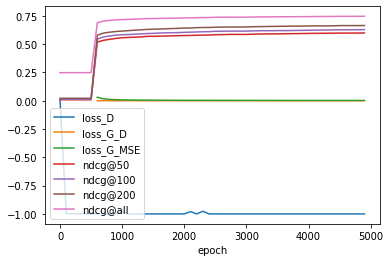

In [58]:
pd.set_option('display.max_rows', 500)
results_df = pd.DataFrame(results)
results_df.groupby(by=['epoch']).mean().plot()
results_df.groupby(by=['epoch']).mean()
# results_df.groupby(by=['epoch']).mean().iloc[-1]

In [61]:
# setting
lr = 0.02
momentum = 0.
weight_decay = 0
nesterov = False # True

bs = 10

n_epoch = 5000
n_critic = 1

loss_weight = [1, 1, 1e-3]
clip_value = 0

verbose = 0

model = Lasso(num_doc=select_num, num_words=word_vectors.shape[0])
D = Discriminator(num_words=word_vectors.shape[0], h_dim=32)

model.train()
D.train()

# opt_G = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
# opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=nesterov)
opt_D = torch.optim.SGD(D.parameters(), lr=lr*10)

G_criterion = nn.MSELoss(reduction='mean')
D_criterion = nn.BCELoss()

results = []
step = 0
for epoch in tqdm(range(n_epoch)):
    
    D_loss = []
    G_loss_D = []
    G_loss_MSE = []
    
    model.train()
    for data in train_loader:
        doc_embs, _, doc_ids = data

        perm = torch.randperm(test_word_weight_tensor.size(0))
        true_word_weights_sample = test_word_weight_tensor[perm[:bs]]

        # Label
        r_label = torch.ones((bs))
        f_label = torch.zeros((doc_embs.size(0)))

        r_logit = D(true_word_weights_sample.detach())
        f_logit = D(model.emb(doc_ids).detach())
        
        # Compute the loss for the discriminator.
        # r_loss = D_criterion(r_logit.squeeze(), r_label)
        # f_loss = D_criterion(f_logit.squeeze(), f_label)
        # loss_D = (r_loss + f_loss) / 2

        # WGAN Loss
        loss_D = -torch.mean(r_logit) + torch.mean(f_logit)

        # Model backwarding
        D.zero_grad()
        loss_D.backward()

        # Update the discriminator.
        opt_D.step()
        
        D_loss.append(loss_D.item())
        """ Clip weights of discriminator. """
        for p in D.parameters():
            p.data.clamp_(-10, 10)

        # ============================================
        #  Train G
        # ============================================
        
        if (epoch % n_critic == 0) and (epoch > 500):
            # Generate some fake images.
            f_imgs = model.emb(doc_ids)
            f_logit = D(f_imgs)
            
            # Compute the loss for the generator.
            # loss_G_Dis = D_criterion(f_logit.squeeze(), torch.ones((doc_embs.size(0))))
            # WGAN Loss
            loss_G_Dis = -torch.mean(f_logit)
            
            # MSE loss
            pred_doc_embs = model(doc_ids, word_vectors_tensor)     
            loss_G_MSE = G_criterion(pred_doc_embs, doc_embs)
            
            emb_w_sum = torch.sum(model.emb(doc_ids), axis=1)
            
            loss_G_SUM = G_criterion(emb_w_sum, torch.ones(emb_w_sum.shape))
            
            loss_G = loss_G_Dis * loss_weight[0] + loss_G_MSE * loss_weight[1] + loss_G_SUM * loss_weight[2]
            # Model backwarding
            model.zero_grad()
            loss_G.backward()

            # Update the generator.
            opt_G.step()
            
            G_loss_D.append(loss_G_Dis.item())
            G_loss_MSE.append(loss_G_MSE.item())
            
            
            for p in model.parameters():
                p.data.clamp_(clip_value, 100)
        step += 1
        
    if epoch % 100 == 0:
        res = {}
        res['epoch'] = epoch
        res['loss_D'] = np.mean(D_loss)
        res['loss_G_D'] = np.mean(G_loss_D)
        res['loss_G_MSE'] = np.mean(G_loss_MSE)

        if verbose==1:
            print('epoch', res['epoch'])
            print('loss D', res['loss_D'])
            print('loss G D', res['loss_G_D'])
            print('loss G MSE', res['loss_G_MSE'])

        res_ndcg = evaluate_GAN_NDCG(model, train_loader, verbose)
        res.update(res_ndcg)
        results.append(res)
        
    results.append(res)

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rco

,loss_D,loss_G_D,loss_G_MSE,ndcg@50,ndcg@100,ndcg@200,ndcg@all
epoch,,,,,,,
0,-0.008067,NaN,NaN,0.008099,0.012895,0.021415,0.247514
100,-0.997792,NaN,NaN,0.008099,0.012895,0.021415,0.247514
200,-0.998910,NaN,NaN,0.008099,0.012895,0.021415,0.247514
300,-0.999512,NaN,NaN,0.008099,0.012895,0.021415,0.247514
400,-0.999736,NaN,NaN,0.008099,0.012895,0.021415,0.247514
500,-0.999715,NaN,NaN,0.008099,0.012895,0.021415,0.247514
600,-0.999777,-0.000217,0.030502,0.517476,0.542964,0.578284,0.687432
700,-0.999771,-0.000217,0.015991,0.534578,0.564996,0.598504,0.704625
800,-0.999879,-0.000120,0.011145,0.545412,0.573532,0.606564,0.710538


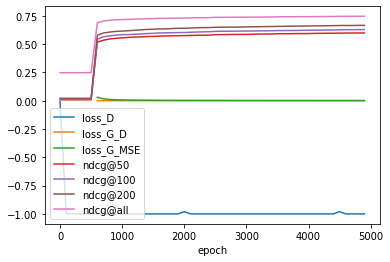

In [62]:
pd.set_option('display.max_rows', 500)
results_df = pd.DataFrame(results)
results_df.groupby(by=['epoch']).mean().plot()
results_df.groupby(by=['epoch']).mean()
# results_df.groupby(by=['epoch']).mean().iloc[-1]

## Quality Check

In [47]:
word_list = dataset.vocab.itos
# select doc_id and k
doc_id = 1
topk = 50

gt = [word_list[word_idx] for word_idx in np.argsort(tfidf_ans[doc_id])[::-1][:topk]]
pred = [word_list[word_idx] for word_idx in np.argsort(model.emb.weight.data[doc_id].numpy())[::-1][:topk]]

print('ground truth\n', gt)
print('prediction\n', pred)

ground truth
 ['homeless', 'street', 'bet', 'molli', 'rich', 'mel', 'brook', 'lose', 'blaze', 'frankenstein', 'monitor', 'iraq', 'sidewalk', 'sissi', 'mutual', 'bathroom', 'sailor', 'elect', 'racism', 'pal', 'warren', 'flight', 'survivor', 'slapstick', 'prior', 'wilson', 'leg', 'tender', 'howard', 'rival', 'succeed', 'thrown', 'ann', 'vote', 'wall', 'lesson', 'month', 'stupid', 'project', 'step', 'connect', 'reach', 'plan', 'georg', 'build', 'caus', 'state', 'futur', 'dean', 'pan']
prediction
 ['street', 'homeless', 'poor', 'whether', 'bet', 'public', 'alright', 'fund', 'dig', 'manhattan', 'elect', 'vote', 'rival', 'fix', 'project', 'hell', 'worst', 'trust', 'sharon', 'fire', 'sick', 'theater', 'ride', 'nina', 'break', 'neighborhood', 'chase', 'harlem', 'pay', 'bond', 'hurt', 'wall', 'pregnant', 'brent', 'park', 'million', 'fox', 'dog', 'ted', 'subway', 'oil', 'cliff', 'eve', 'drain', 'hey', 'program', 'grade', 'difficult', 'alley', 'rich']


## LassoGAN train seperately

In [ ]:
def evaluate_GAN_NDCG(w, tfidf_ans, doc_id, verbose=1):
    results = {}
    
    scores = w.detach().numpy().reshape(1, -1)
    true_relevance = tfidf_ans[doc_id].reshape(1, -1)

    
    results['ndcg@50'] = (ndcg_score(true_relevance, scores, k=50))
    results['ndcg@100'] = (ndcg_score(true_relevance, scores, k=100))
    results['ndcg@200'] = (ndcg_score(true_relevance, scores, k=200))
    results['ndcg@all'] = (ndcg_score(true_relevance, scores, k=None))
    
    if verbose == 1:
        print('NDCG top50', results['ndcg@50'])
        print('NDCG top100', results['ndcg@100'])
        print('NDCG top200', results['ndcg@200'])
        print('NDCG ALL', results['ndcg@all'])
    
    return results

In [ ]:
lr = 0.001
n_epoch = 1000

n_critic = 1
clip_value = 1
bs = 1
loss_weight = [0, 1]

num_words = word_vectors.shape[0]
results_all = []

for doc_id in tqdm(range(len(document_vectors_tensor[:10]))):
    doc_emb = document_vectors_tensor[doc_id]
    test_word_weight_tensor = torch.FloatTensor(np.concatenate((tfidf_ans[:doc_id], tfidf_ans[doc_id+1:])))

    w = torch.zeros(num_words).requires_grad_(True)
    D = Discriminator(num_words=num_words, h_dim=64)
    D.train()

    # opt_G = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
    # opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_G = torch.optim.SGD([w], lr=lr)
    opt_D = torch.optim.SGD(D.parameters(), lr=lr)

    G_criterion = nn.MSELoss(reduction='mean')
    D_criterion = nn.BCELoss()

    results = []
    for epoch in range(n_epoch):

        D_loss = []
        G_loss_D = []
        G_loss_MSE = []

        perm = torch.randperm(test_word_weight_tensor.size(0))
        true_word_weights_sample = test_word_weight_tensor[perm[:bs]]
        """ Medium: Use WGAN Loss. """
        # Label
        r_label = torch.ones((bs))
        f_label = torch.zeros((bs))

        # Model forwarding
        r_logit = D(true_word_weights_sample.detach())
        f_logit = D(w.detach())

        # Compute the loss for the discriminator.
        # r_loss = D_criterion(r_logit.squeeze(), r_label)
        # f_loss = D_criterion(f_logit.squeeze(), f_label)
        # loss_D = (r_loss + f_loss) / 2

        # WGAN Loss
        loss_D = -torch.mean(r_logit) + torch.mean(f_logit)

        # Model backwarding
        D.zero_grad()
        loss_D.backward()

        # Update the discriminator.
        opt_D.step()

        D_loss.append(loss_D.item())
        """ Medium: Clip weights of discriminator. """
        for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # ============================================
        #  Train G
        # ============================================
        if epoch % n_critic == 0:
            # Generate some fake images.
            f_logit = D(w)

            """ Medium: Use WGAN Loss"""
            # Compute the loss for the generator.
            # loss_G_Dis = D_criterion(f_logit.squeeze(), r_label)
            # WGAN Loss
            loss_G_Dis = -torch.mean(f_logit)

            # MSE loss
            pred_doc_embs = w @ word_vectors_tensor
            loss_G_MSE = G_criterion(pred_doc_embs, doc_emb)

            loss_G = loss_G_Dis * loss_weight[0] + loss_G_MSE * loss_weight[1]

            # Model backwarding
            if w.grad is not None:
                w.grad.zero_()
            
            loss_G.backward()
            
            # Update the generator.
            opt_G.step()

            G_loss_D.append(loss_G_Dis.item())
            G_loss_MSE.append(loss_G_MSE.item())
        
        if epoch % 20 == 0:
            res = {}
            res['epoch'] = epoch
            res['loss_D'] = np.mean(D_loss)
            res['loss_G_D'] = np.mean(G_loss_D)
            res['loss_G_MSE'] = np.mean(G_loss_MSE)
            
            print('epoch', epoch)
            print('loss D', np.mean(D_loss))
            print('loss G D', np.mean(G_loss_D))
            print('loss G MSE', np.mean(G_loss_MSE))
            
            res_ndcg = evaluate_GAN_NDCG(w, tfidf_ans, doc_id)
            res.update(res_ndcg)
            results.append(res)

    results_all.append(results)

In [ ]:
results_df = []
for r in results_all:
    r = pd.DataFrame(r)
    results_df.append(r)

results_df = pd.concat(results_df)
results_df.groupby(by=['epoch']).mean().plot()
results_df.groupby(by=['epoch']).mean()
# results_df.groupby(by=['epoch']).mean().iloc[-1]

## Nearest Guessing, so bad

In [ ]:
word_embs_IDF = word_embs.copy()

for word, IDF in dataset.vocab.IDF.items():
    word_idx = dataset.vocab.stoi[word]
    word_embs_IDF[word_idx] *= IDF

In [ ]:
pr, re = [[],[],[]], [[],[],[]]
ndcgs = defaultdict(list)

for uid, uemb in enumerate(tqdm(doc_embs[:100])):
    y = uemb
    word_embs_IDF
    word_weight = np.dot(word_embs_IDF, y)
    
    m1 = metric4(word_weight, doc_answers[uid], w_idx=None, topk=50, verbose=0)
    m2 = metric4(word_weight, doc_answers[uid], w_idx=None, topk=100, verbose=0)
    m3 = metric4(word_weight, doc_answers[uid], w_idx=None, topk=200, verbose=0)
    ndcg1 = metric_ndcg(word_weight, doc_answers[uid], topk=50, verbose=0)
    ndcg2 = metric_ndcg(word_weight, doc_answers[uid], topk=100, verbose=0)
    ndcg3 = metric_ndcg(word_weight, doc_answers[uid], topk=200, verbose=0)
    ndcg4 = metric_ndcg(word_weight, doc_answers[uid], topk=None, verbose=0)
    pr[0].append(m1["precision"])
    re[0].append(m1["recall"])
    pr[1].append(m2["precision"])
    re[1].append(m2["recall"])
    pr[2].append(m3["precision"])
    re[2].append(m3["recall"])
    
    ndcgs["50"].append(ndcg1)
    ndcgs["100"].append(ndcg2)
    ndcgs["200"].append(ndcg3)
    ndcgs["-1"].append(ndcg4)

In [ ]:
print(f"Precision:{np.mean(pr[0]):.4f} Recall:{np.mean(re[0]):.4f}")
print(f"Precision:{np.mean(pr[1]):.4f} Recall:{np.mean(re[1]):.4f}")
print(f"Precision:{np.mean(pr[2]):.4f} Recall:{np.mean(re[2]):.4f}")
print(f"NDCG 50:{np.mean(ndcgs['50']):.4f}")
print(f"NDCG 100:{np.mean(ndcgs['100']):.4f}")
print(f"NDCG 200:{np.mean(ndcgs['200']):.4f}")
print(f"NDCG all:{np.mean(ndcgs['-1']):.4f}")


In [ ]:
# ## test dcg
# from sklearn.metrics import ndcg_score, dcg_score
# k=2

# true_relevance = np.asarray([[1, 2, 3, 4]])
# scores = np.asarray([[1, 2, 3, 2.5]])
# print('dcg',dcg_score(true_relevance, scores,k=k))
# print('ndcg',ndcg_score(true_relevance, scores,k=k))


# w = 1 / (np.log(np.arange(true_relevance.shape[1])[:k] + 2) / np.log(2))
# dcg = true_relevance[0][np.argsort(scores)[0][::-1][:k]].dot(w)
# print(dcg)

# idcg = np.sort(true_relevance[0])[::-1][:k].dot(w)
# print(dcg/idcg)